In [1]:
import os
import sys
sys.path.append(os.path.abspath("/users/amtseng/tfmodisco/src/"))
sys.path.append(os.path.abspath("/users/amtseng/tfmodisco/notebooks/reports/"))
import util
import motif.read_motifs as read_motifs
import motif.moods as moods
import plot.viz_sequence as viz_sequence
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import tempfile
import tqdm
tqdm.tqdm_notebook(range(1))

/users/amtseng/miniconda3/envs/tfmodisco-mini/lib/python3.7/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


  0%|          | 0/1 [00:00<?, ?it/s]

In [2]:
# Plotting defaults
font_manager.fontManager.ttflist.extend(
    font_manager.createFontList(
        font_manager.findSystemFonts(fontpaths="/users/amtseng/modules/fonts")
    )
)
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold",
    "svg.fonttype": "none"
}
plt.rcParams.update(plot_params)

/users/amtseng/miniconda3/envs/tfmodisco-mini/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  after removing the cwd from sys.path.


### Define constants and paths

In [3]:
out_path = "/users/amtseng/tfmodisco/figures/ZNF248_pwm_vs_cwm"
os.makedirs(out_path, exist_ok=True)

In [4]:
tfm_motifs_path = os.path.join(
    "/users/amtseng/tfmodisco/results/reports/tfmodisco_results/cache/",
    "ZNF248",
    "ZNF248_ChIPexo",
    "ZNF248_ChIPexo_count",
    "all_motifs.h5"
)

homer25_motifs_path = "/users/amtseng/tfmodisco/results/classic_motifs/peaks/ZNF248/ZNF248_ChIPExo/homer_25"
homer50_motifs_path = "/users/amtseng/tfmodisco/results/classic_motifs/peaks/ZNF248/ZNF248_ChIPExo/homer_50"
meme_motifs_path = "/users/amtseng/tfmodisco/results/classic_motifs/peaks/ZNF248/ZNF248_ChIPExo/memechip/meme_out"

b1h_motif_path = "/users/amtseng/tfmodisco/data/processed/B1H/ZNF248_B1Hcode.txt"

moods_hits_dir = "/users/amtseng/tfmodisco/results/moods/ZNF248/"
reference_fasta_path = "/users/amtseng/genomes/hg38.fasta"
peaks_bed_path = "/users/amtseng/tfmodisco/data/processed/ZNF248/labels/ChIPexo/ZNF248_Exo_HEK239T_all_peakints.bed.gz"

profiles_hdf5_path = "/users/amtseng/tfmodisco/data/processed/ZNF248/labels/ChIPexo/ZNF248_profiles.h5"
imp_scores_hdf5_path = "/users/amtseng/tfmodisco/results/importance_scores/ZNF248/ZNF248_ChIPexo_shap_scores.h5"
hyp_score_key = "count_hyp_scores"

### PWM vs CWM vs B1H

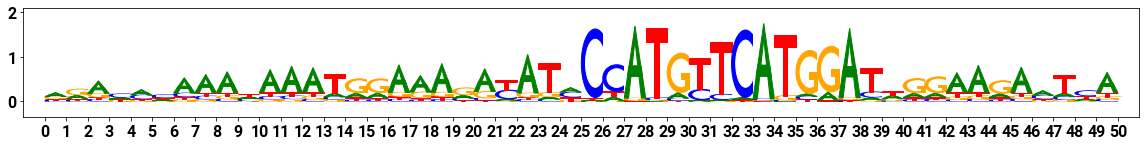

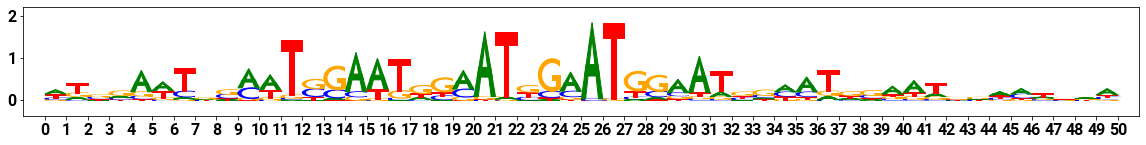

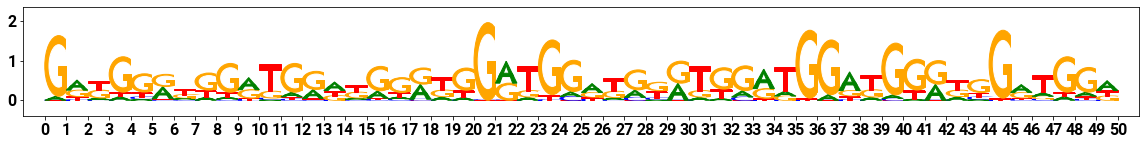

In [5]:
# Import and show TF-MoDISco motifs
with h5py.File(tfm_motifs_path, "r") as f:
    tfm_pfms, tfm_cwms = {}, {}
    tfm_motif_keys = []
    for key in f.keys():
        tfm_pfms[key] = f[key]["pfm_trimmed"][:]
        tfm_cwms[key] = f[key]["cwm_trimmed"][:]
        if not np.all(tfm_pfms[key] == util.purine_rich_motif(tfm_pfms[key])):
            tfm_pfms[key] = util.purine_rich_motif(tfm_pfms[key])
            tfm_cwms[key] = util.purine_rich_motif(tfm_cwms[key])
        tfm_motif_keys.append(key)
        
for key in tfm_motif_keys:
    viz_sequence.plot_weights(read_motifs.pfm_to_pwm(tfm_pfms[key]))

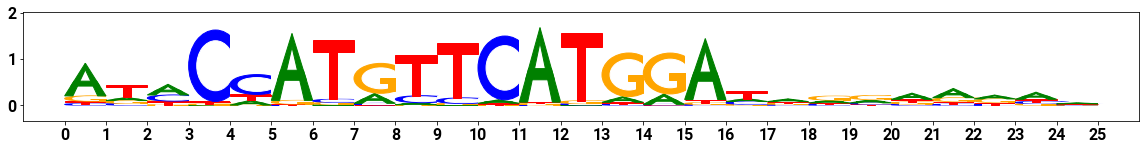

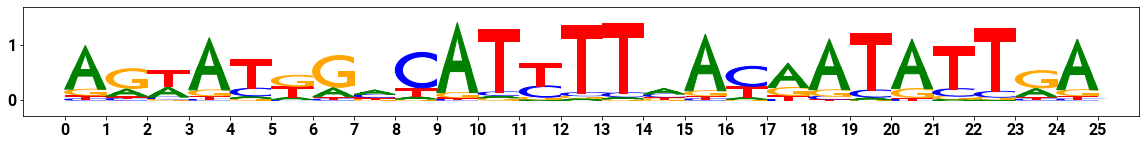

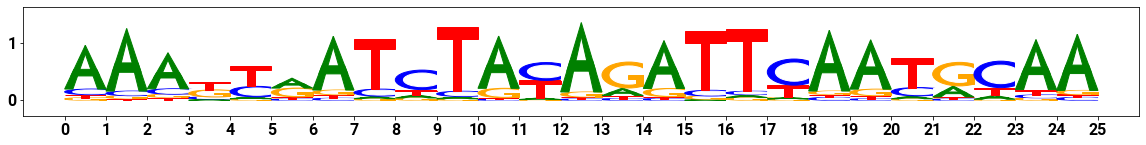

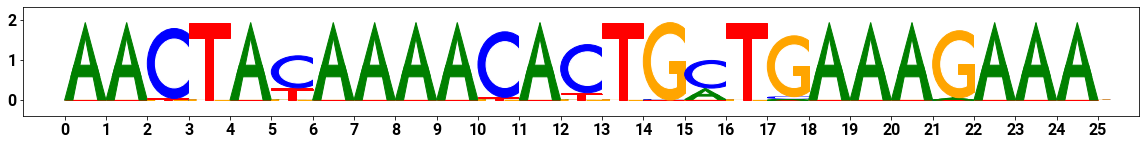

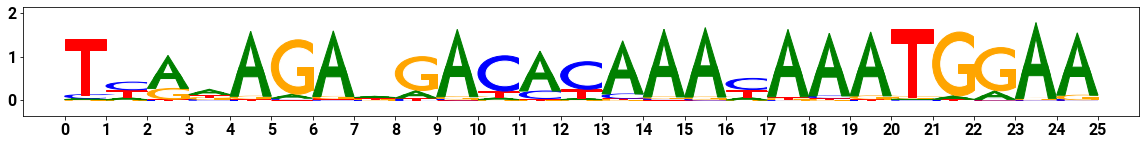

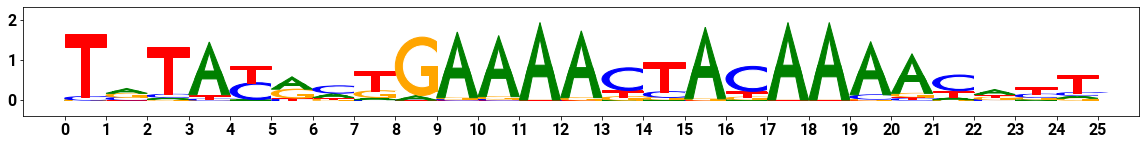

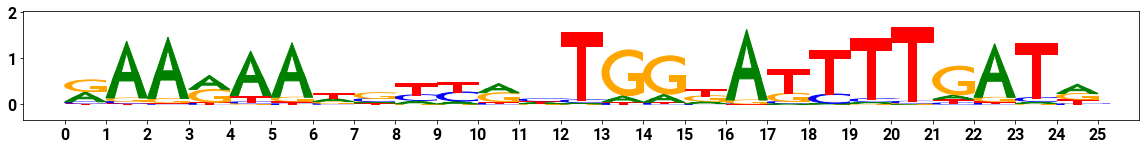

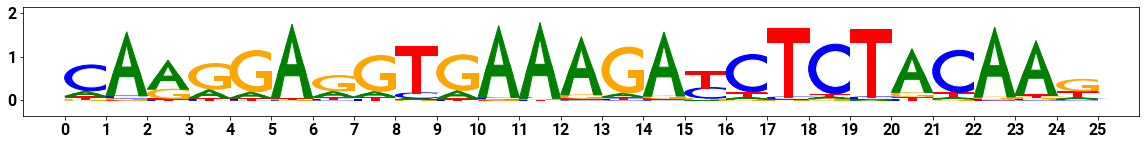

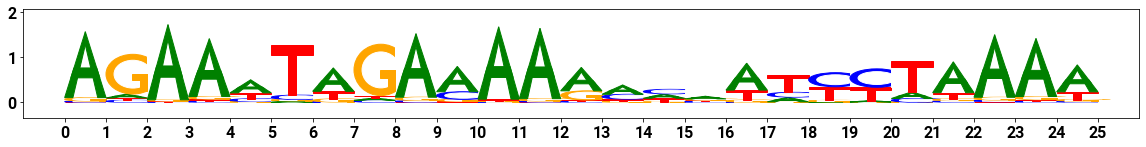

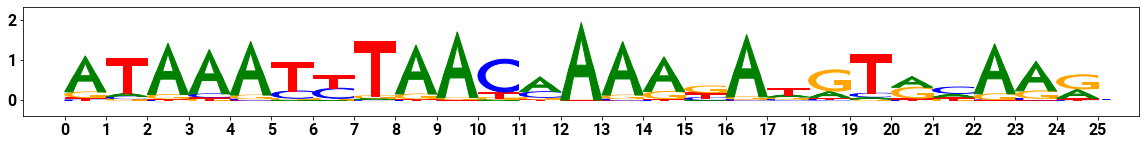

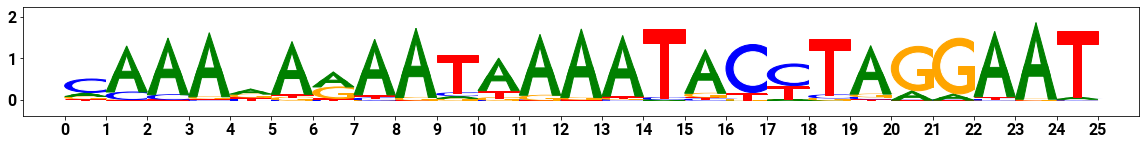

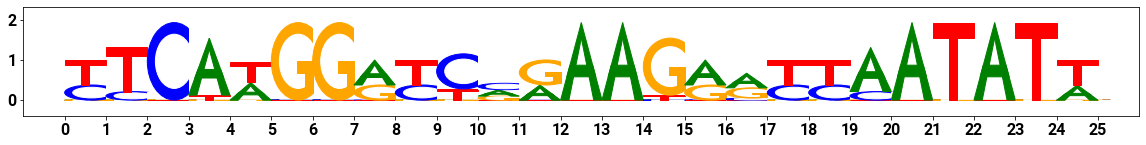

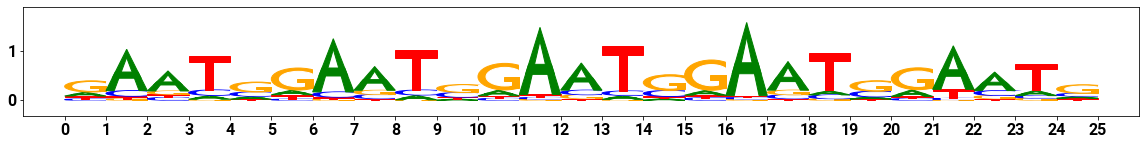

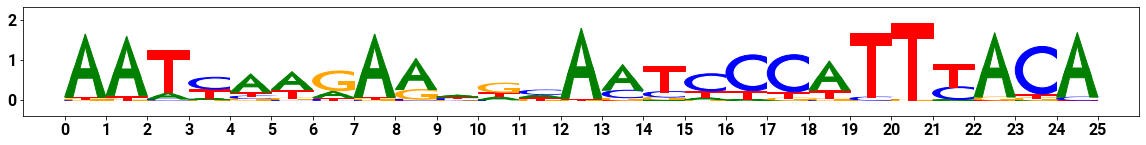

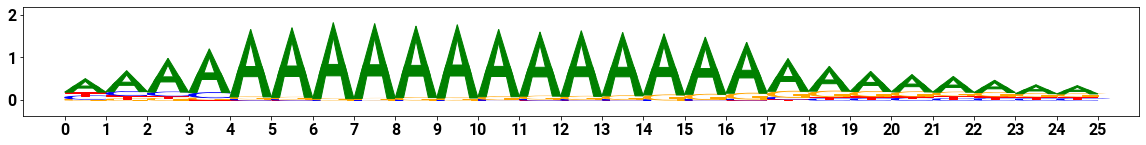

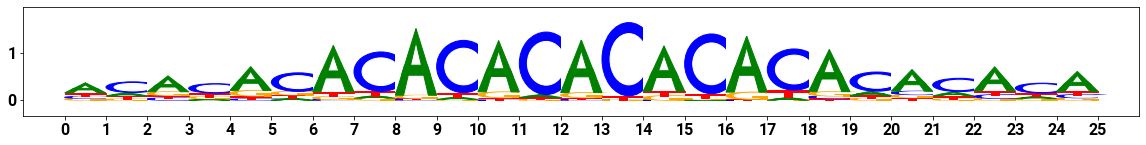

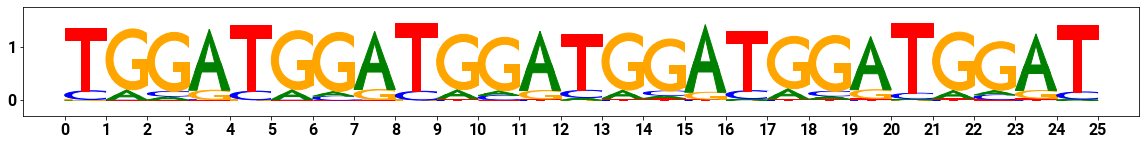

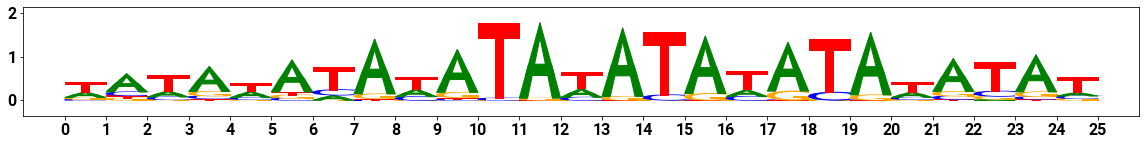

In [6]:
# Import and show HOMER 25 motifs
homer25_pfms = [util.purine_rich_motif(pfm) for pfm in read_motifs.import_homer_pfms(homer25_motifs_path)[0]]

for pfm in homer25_pfms:
    viz_sequence.plot_weights(read_motifs.pfm_to_pwm(pfm))

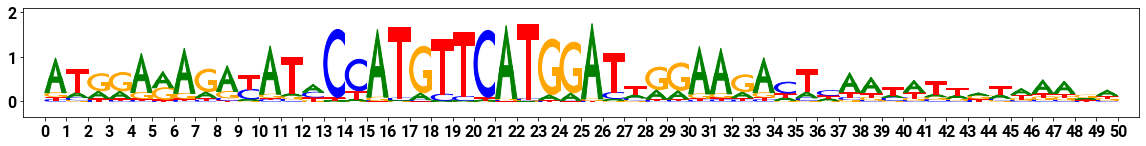

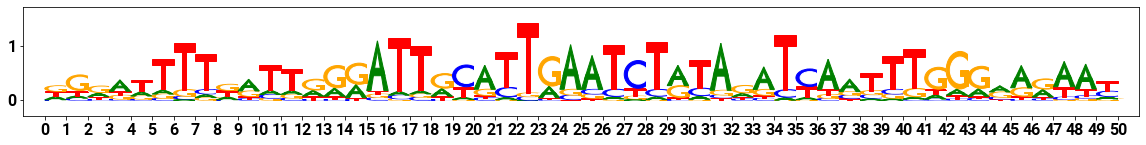

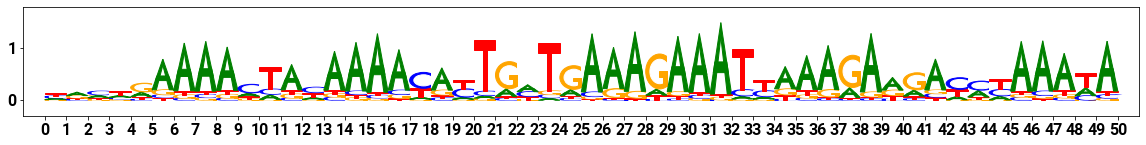

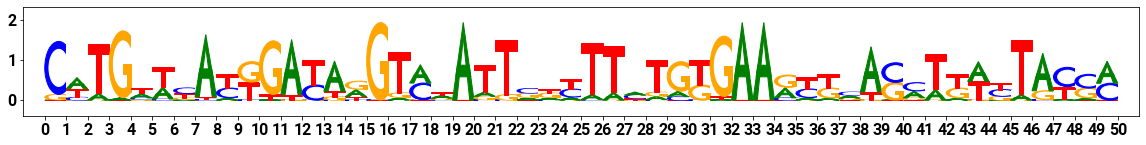

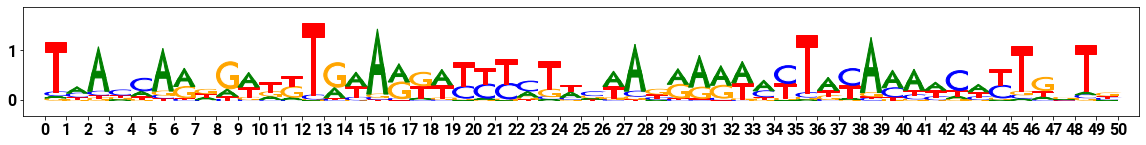

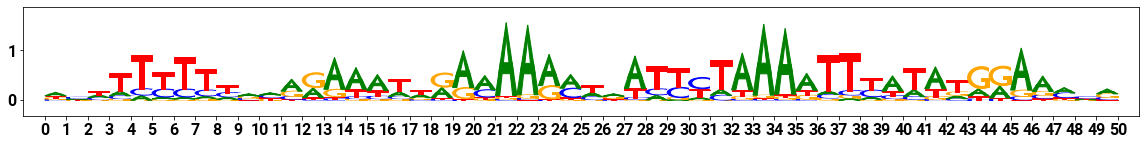

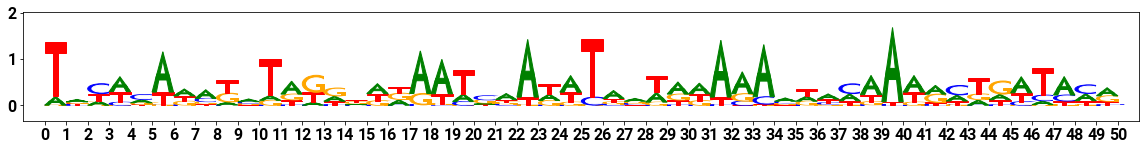

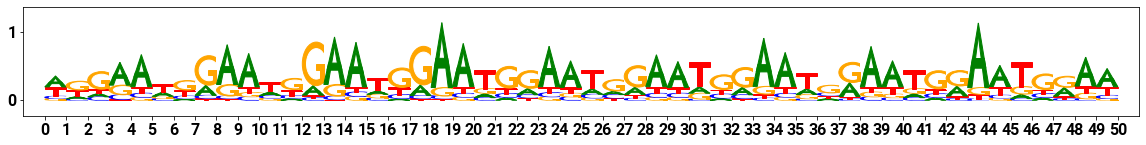

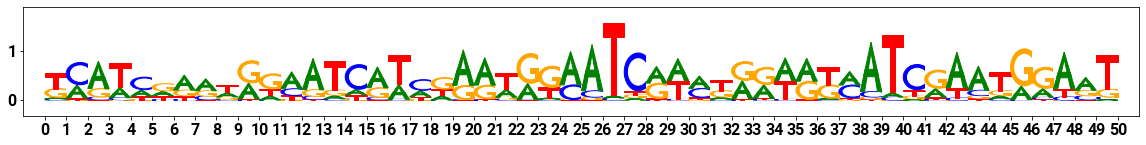

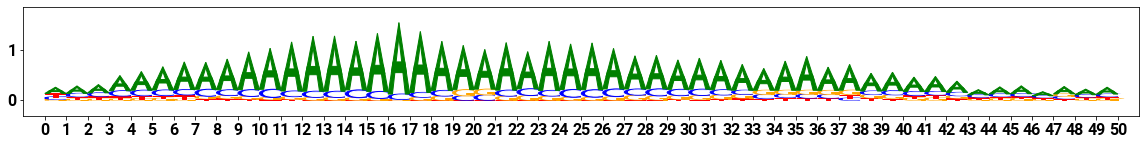

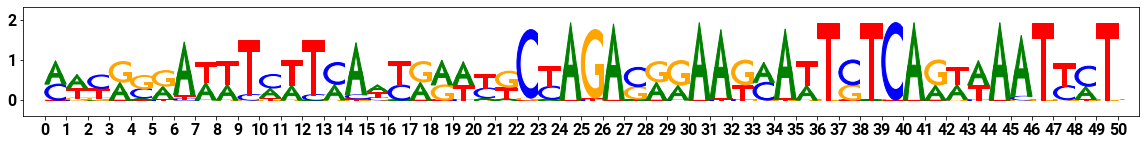

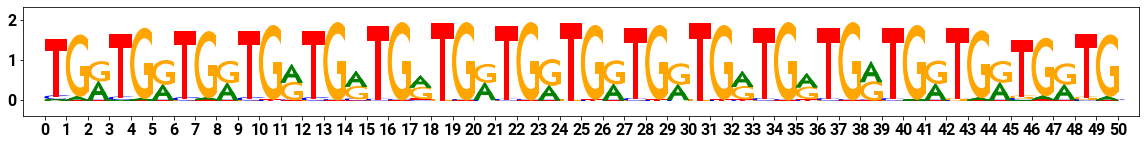

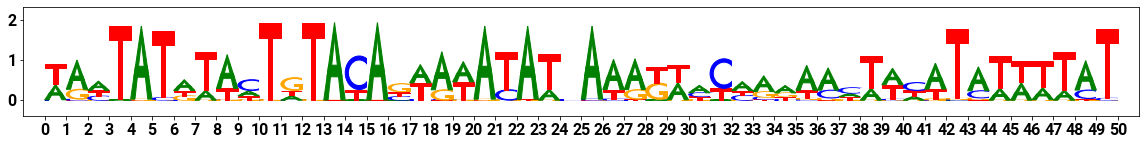

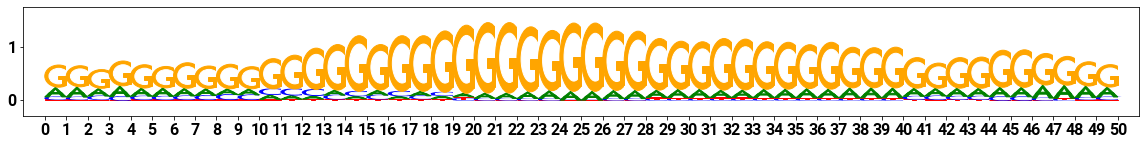

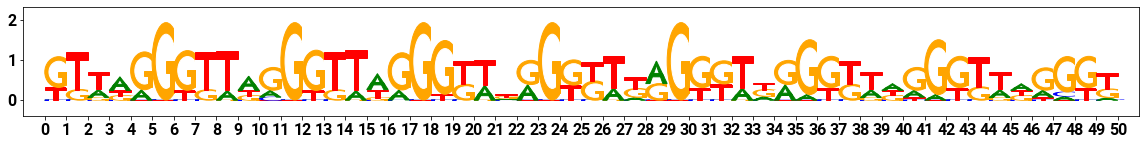

In [7]:
# Import and show HOMER 50 motifs
homer50_pfms = [util.purine_rich_motif(pfm) for pfm in read_motifs.import_homer_pfms(homer50_motifs_path)[0]]

for pfm in homer50_pfms:
    viz_sequence.plot_weights(read_motifs.pfm_to_pwm(pfm))

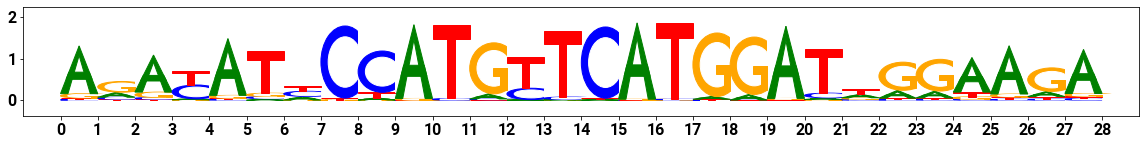

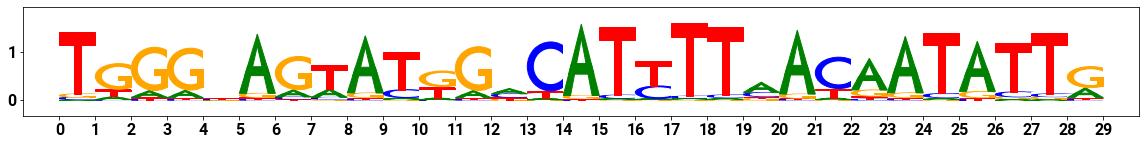

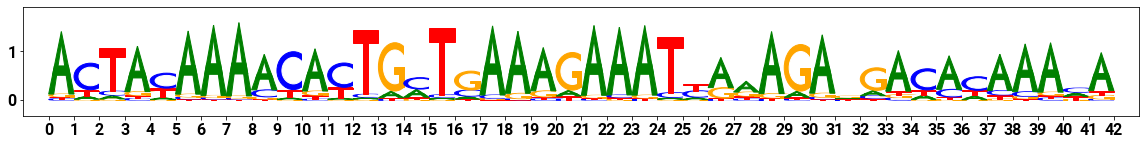

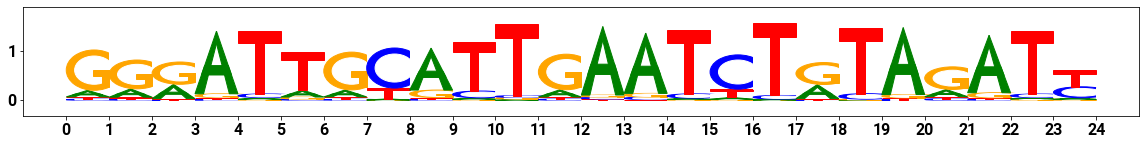

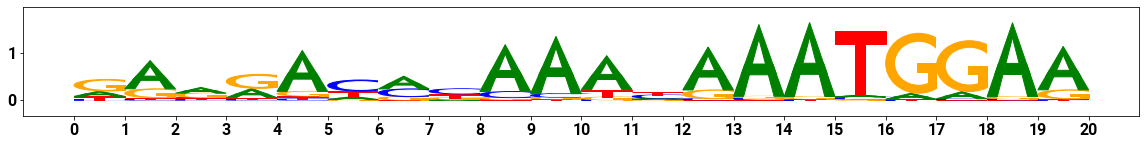

In [8]:
# Import and show MEME motifs
meme_pfms = [util.purine_rich_motif(pfm) for pfm in read_motifs.import_meme_pfms(meme_motifs_path)[0]]

for pfm in meme_pfms:
    viz_sequence.plot_weights(read_motifs.pfm_to_pwm(pfm))

In [9]:
# Import B1H recognition code
with open(b1h_motif_path, "r") as f:
    line = next(f)
    while not line.startswith("Pos"):
        line = next(f)
    rows = []
    for line in f:
        tokens = line.strip().split("\t")[1:]
        if len(tokens) != 4:
            continue
        rows.append(np.array([float(x) for x in tokens]))
b1h_code = np.stack(rows)

In [10]:
# Align the B1H recognition to the TF-MoDISco motifs
b1h_code_aligned = np.zeros((50, 4))
b1h_code_aligned[20 : 20 + 21] = b1h_code

In [11]:
# Align the benchmark motifs to the TF-MoDISco motifs
homer25_aligned = np.zeros((50, 4))
homer25_aligned[22:22 + 25] = homer25_pfms[0]

homer50_aligned = np.zeros((50, 4))
homer50_aligned[12:] = homer50_pfms[0][:50 - 12]

meme_aligned = np.zeros((50, 4))
meme_aligned[18:18 + len(meme_pfms[0])] = meme_pfms[0]

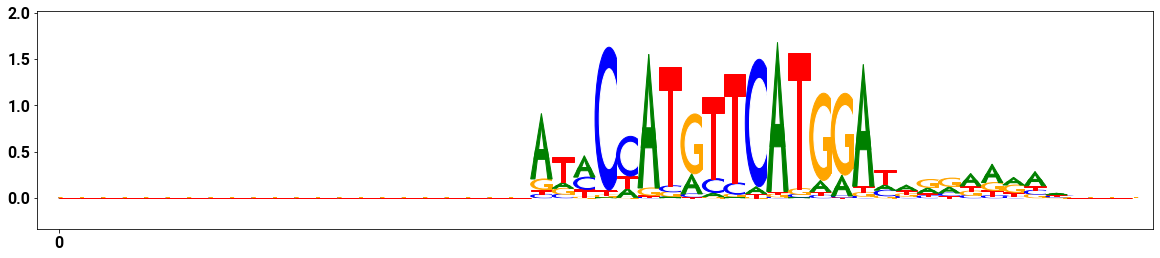

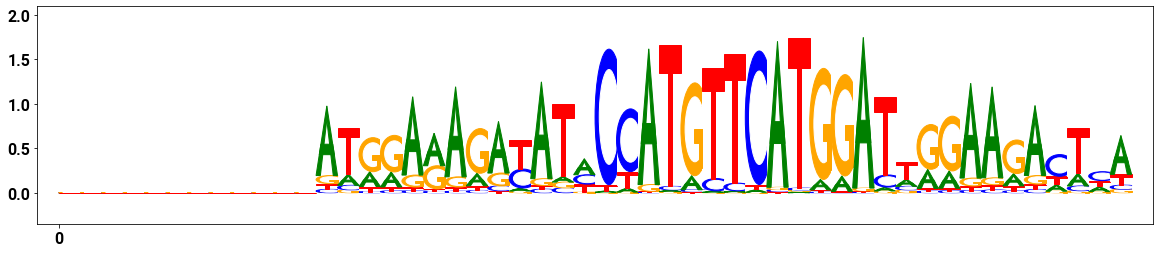

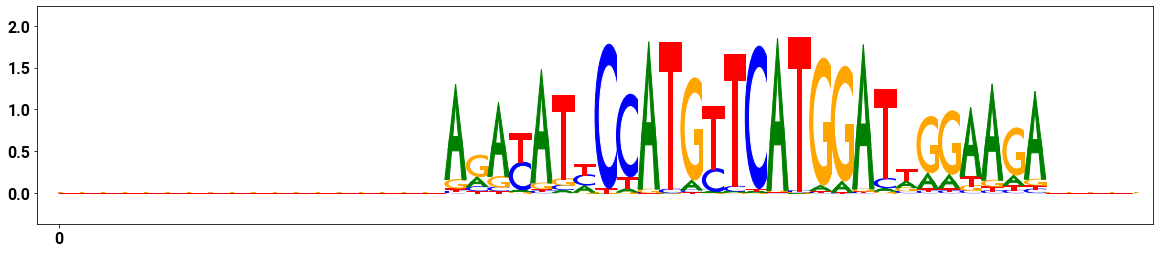

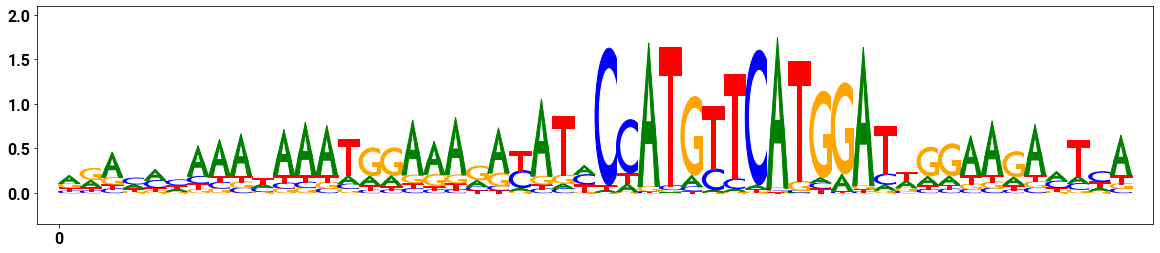

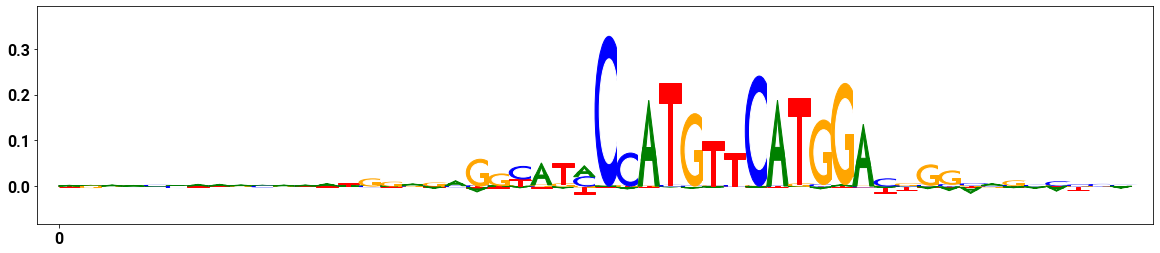

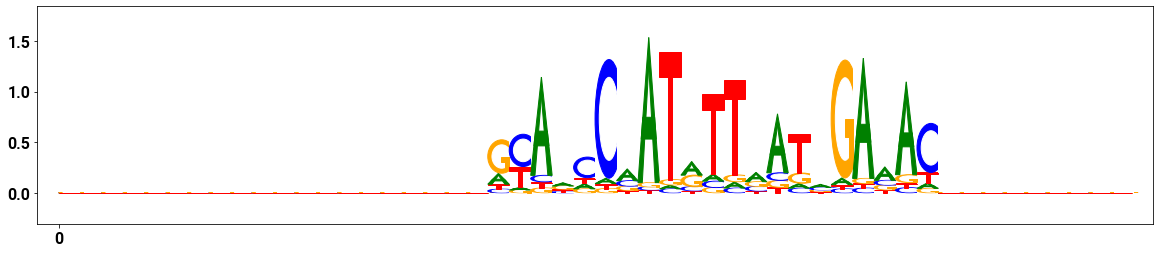

In [12]:
viz_sequence.plot_weights(read_motifs.pfm_to_pwm(homer25_aligned), subticks_frequency=100, figsize=(20, 4), return_fig=True)
plt.savefig(
    os.path.join(out_path, "ZNF248_homer25_pwm.svg"),
    format="svg"
)

viz_sequence.plot_weights(read_motifs.pfm_to_pwm(homer50_aligned), subticks_frequency=100, figsize=(20, 4), return_fig=True)
plt.savefig(
    os.path.join(out_path, "ZNF248_homer50_pwm.svg"),
    format="svg"
)

viz_sequence.plot_weights(read_motifs.pfm_to_pwm(meme_aligned), subticks_frequency=100, figsize=(20, 4), return_fig=True)
plt.savefig(
    os.path.join(out_path, "ZNF248_meme_pwm.svg"),
    format="svg"
)

viz_sequence.plot_weights(read_motifs.pfm_to_pwm(tfm_pfms["0_0"]), subticks_frequency=100, figsize=(20, 4), return_fig=True)
plt.savefig(
    os.path.join(out_path, "ZNF248_tfm_pwm.svg"),
    format="svg"
)
viz_sequence.plot_weights(tfm_cwms["0_0"], subticks_frequency=100, figsize=(20, 4), return_fig=True)
plt.savefig(
    os.path.join(out_path, "ZNF248_tfm_cwm.svg"),
    format="svg"
)

viz_sequence.plot_weights(read_motifs.pfm_to_pwm(b1h_code_aligned), subticks_frequency=100, figsize=(20, 4), return_fig=True)
plt.savefig(
    os.path.join(out_path, "ZNF248_B1H.svg"),
    format="svg"
)

### Distribution of core motifs and TE

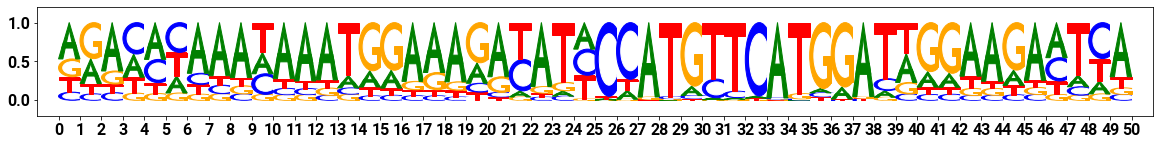

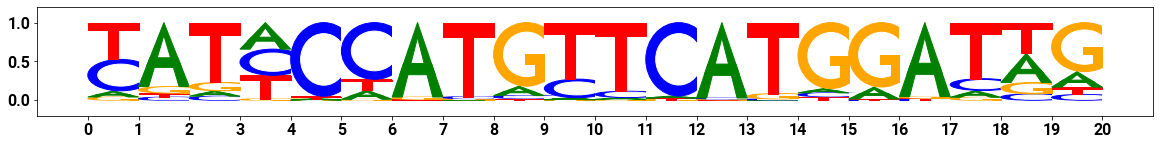

In [13]:
# Construct and export motifs in MOODS-ready format
full_pfm = tfm_pfms["0_0"]
core_pfm = full_pfm[21:41]

viz_sequence.plot_weights(full_pfm)
viz_sequence.plot_weights(core_pfm)

moods.export_motifs({"core": core_pfm, "full": full_pfm}, moods_hits_dir)

In [14]:
hits_bed_path = os.path.join(moods_hits_dir, "moods_out_filtered.bed")
if not os.path.exists(hits_bed_path):
    moods.run_moods(moods_hits_dir, reference_fasta_path)
    moods.moods_hits_to_bed(
        os.path.join(moods_hits_dir, "moods_out.csv"), os.path.join(moods_hits_dir, "moods_out.bed")
    )
    
    # Create peak bed expanded to 400 base pairs
    center_cut_size = 400
    peaks_table = pd.read_csv(
        peaks_bed_path, sep="\t", header=None, index_col=False,
        usecols=[0, 1, 2, 9],
        names=["chrom", "start", "end", "summit_offset"]
    )
    peaks_table["start"] = \
        (peaks_table["start"] + peaks_table["summit_offset"]) - \
        (center_cut_size // 2)
    peaks_table["end"] = peaks_table["start"] + center_cut_size
    # Make sure nothing is negative
    peaks_table["min"] = 0
    peaks_table["start"] = peaks_table[["start", "min"]].max(axis=1)
    del peaks_table["min"]
    peaks_table[["chrom", "start", "end"]].to_csv(
        os.path.join(moods_hits_dir, "peaks_cut.bed"), sep="\t",
        header=False, index=False
    )
    filter_peak_bed_path = os.path.join(moods_hits_dir, "peaks_cut.bed")
    
    # Filter for peaks
    moods.filter_hits_for_peaks(
        os.path.join(moods_hits_dir, "moods_out.bed"), hits_bed_path,
        filter_peak_bed_path
    )

In [15]:
def import_hit_table(path):
    return pd.read_csv(
        path, sep="\t", header=None, index_col=False,
        names=["chrom", "start", "end", "key", "strand", "score", "peak_index"]
    )

In [16]:
# Import hits table
hit_table = import_hit_table(hits_bed_path)

In [17]:
core_hits_table = hit_table[hit_table["key"] == "core"]
full_hits_table = hit_table[hit_table["key"] == "full"]

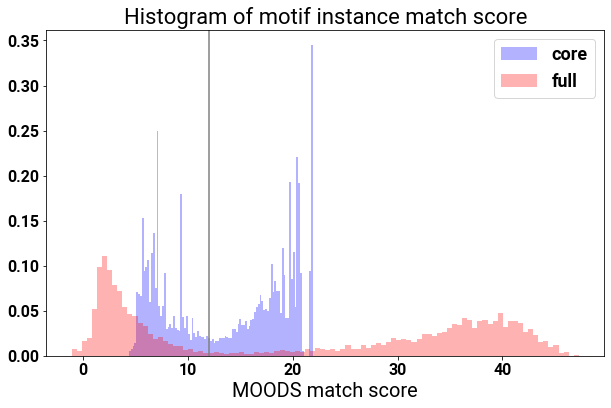

In [18]:
min_score = 12

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(core_hits_table["score"], bins=100, color="blue", label="core", density=True, alpha=0.3)
ax.hist(full_hits_table["score"], bins=100, color="red", label="full", density=True, alpha=0.3)
ax.axvline(min_score, color="gray")
ax.set_title("Histogram of motif instance match score")
ax.set_xlabel("MOODS match score")
plt.legend()
plt.show()

In [19]:
# Limit to high-scoring motif hits
core_hits_table = core_hits_table[core_hits_table["score"] >= min_score]
full_hits_table = full_hits_table[full_hits_table["score"] >= min_score]

In [20]:
core_peaks, full_peaks = np.unique(core_hits_table["peak_index"]), np.unique(full_hits_table["peak_index"])
core_shared_peaks = np.intersect1d(core_peaks, full_peaks)
core_unique_peaks, full_unique_peaks = np.setdiff1d(core_peaks, full_peaks), np.setdiff1d(full_peaks, core_peaks)
print("Number of core peaks: %d" % len(core_peaks))
print("Number of full peaks: %d" % len(full_peaks))
print("Number of shared peaks: %d" % len(core_shared_peaks))
print("Number of unique core peaks: %d" % len(core_unique_peaks))
print("Number of unique full peaks: %d" % len(full_unique_peaks))

Number of core peaks: 4689
Number of full peaks: 4687
Number of shared peaks: 4532
Number of unique core peaks: 157
Number of unique full peaks: 155


In [21]:
# Get set of core and full hits that overlap, unique core, and unique full hits
core_f = tempfile.NamedTemporaryFile("w")
full_f = tempfile.NamedTemporaryFile("w")

core_shared_f = tempfile.NamedTemporaryFile("w")
core_unique_f = tempfile.NamedTemporaryFile("w")
full_unique_f = tempfile.NamedTemporaryFile("w")

core_hits_table.to_csv(core_f, header=False, sep="\t", index=False)
full_hits_table.to_csv(full_f, header=False, sep="\t", index=False)

!bedtools intersect -a {core_f.name} -b {full_f.name} -u > {core_shared_f.name}
!bedtools intersect -a {core_f.name} -b {full_f.name} -v > {core_unique_f.name}
!bedtools intersect -b {core_f.name} -a {full_f.name} -v > {full_unique_f.name}

core_shared_hits_table = import_hit_table(core_shared_f.name)
core_unique_hits_table = import_hit_table(core_unique_f.name)
full_unique_hits_table = import_hit_table(full_unique_f.name)

for f in (core_f, full_f, core_shared_f, core_unique_f, full_unique_f):
    f.close()
    
print("Number of core hits: %d" % len(core_hits_table))
print("Number of full hits: %d" % len(full_hits_table))
print("Number of shared hits: %d" % len(core_shared_hits_table))
print("Number of unique core hits: %d" % len(core_unique_hits_table))
print("Number of unique full hits: %d" % len(full_unique_hits_table))

Number of core hits: 4717
Number of full hits: 4735
Number of shared hits: 4515
Number of unique core hits: 162
Number of unique full hits: 186


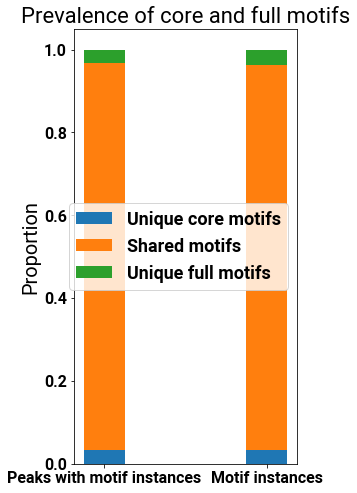

In [22]:
bar_labels = ["Peaks with motif instances", "Motif instances"]
segment_labels = ["Unique core motifs", "Shared motifs", "Unique full motifs"]
core_unique = np.array([len(core_unique_peaks), len(core_unique_hits_table)])
core_shared = np.array([len(core_shared_peaks), len(core_shared_hits_table)])
full_unique = np.array([len(full_unique_peaks), len(full_unique_hits_table)])

total = core_unique + core_shared + full_unique
core_unique = core_unique / total
core_shared = core_shared / total
full_unique = full_unique / total

fig, ax = plt.subplots(figsize=(4, 8))
ax.bar(bar_labels, core_unique, label=segment_labels[0], width=0.25)
ax.bar(bar_labels, core_shared, bottom=core_unique, label=segment_labels[1], width=0.25)
ax.bar(bar_labels, full_unique, bottom=(core_unique + core_shared), label=segment_labels[2], width=0.25)
ax.set_title("Prevalence of core and full motifs")
ax.set_ylabel("Proportion")

ax.legend()

plt.savefig(
    os.path.join(out_path, "ZNF248_core_full_prevalence.svg"), format="svg"
)
plt.show()

### Show an example of a TE motif instance

In [23]:
def plot_example_hit(chrom, start, end, prof_center_size=1000, score_center_size=200, save_path=None):
    """
    For a given putative motif hit, plots the ChIP-nexus and ChIP-seq
    profiles, as well as the importance scores for the task around the
    hit.
    """
    mid = (start + end) // 2
    prof_start = mid - (prof_center_size // 2)
    prof_end = prof_start + prof_center_size
    score_start = mid - (score_center_size // 2)
    score_end = score_start + score_center_size
    
    with h5py.File(profiles_hdf5_path, "r") as f:
        profs = f[chrom][prof_start:prof_end][:, 0]
    with h5py.File(imp_scores_hdf5_path, "r") as f:
        match_inds = np.where(
            (f["coords_chrom"][:].astype(str) == chrom) &
            (f["coords_start"][:] < score_start) &
            (f["coords_end"][:] > score_end)
        )[0]
        if not match_inds.size:
            print("Warning: did not find sufficiently large importance score track for %s:%d-%s" % (chrom, score_start, score_end))
            return
        
        match_ind = match_inds[0]
        
        coord_start, coord_end = f["coords_start"][match_ind], f["coords_end"][match_ind]
        hyp_scores = f[hyp_score_key][match_ind]
        one_hot_seq = f["input_seqs"][match_ind]
        
        cut_start = score_start - coord_start
        cut_end = cut_start + score_center_size
        hyp_scores = hyp_scores[cut_start:cut_end]
        one_hot_seq = one_hot_seq[cut_start:cut_end]
        
    prof_fig, ax = plt.subplots(figsize=(20, 4))
    ax.plot(profs[:, 0], color="darkslateblue")
    ax.plot(-profs[:, 1], color="darkorange")
    ax.set_title("ChIP-exo profiles")
    # Draw vertical lines that denote the portion with importance scores
    ax.axvline(score_start - prof_start, color="gray")
    ax.axvline(score_end - prof_start, color="gray")
    if save_path:
        plt.savefig(
            os.path.join(save_path + "_profiles.svg"), format="svg"
        )
    plt.show()

    score_fig = viz_sequence.plot_weights(
        hyp_scores * one_hot_seq, figsize=(20, 4), subticks_frequency=score_center_size, return_fig=True
    )
    score_fig.tight_layout()
    if save_path:
        plt.savefig(
            os.path.join(save_path + "_impscores.svg"), format="svg"
        )
    plt.show()

chr1:231143722-231143772 (index 1615)


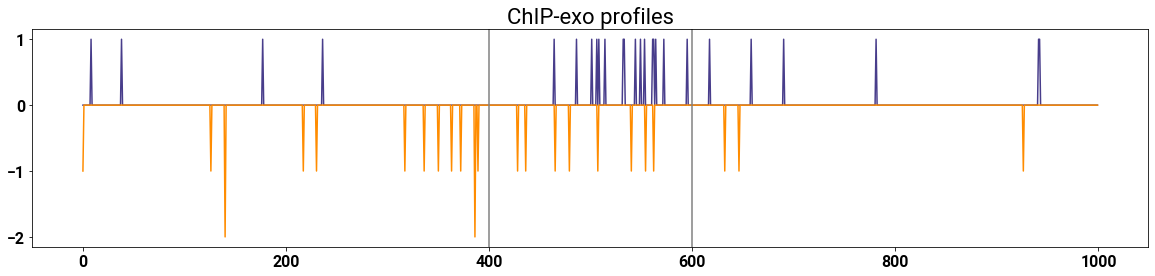

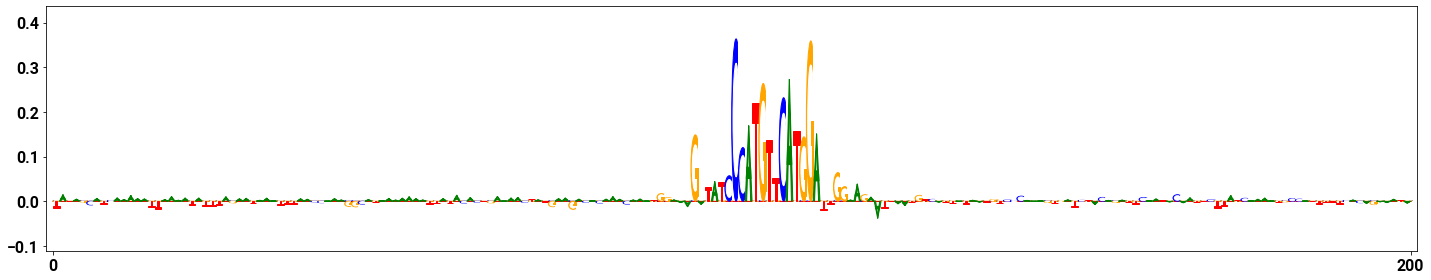

chr8:81567152-81567202 (index 8571)


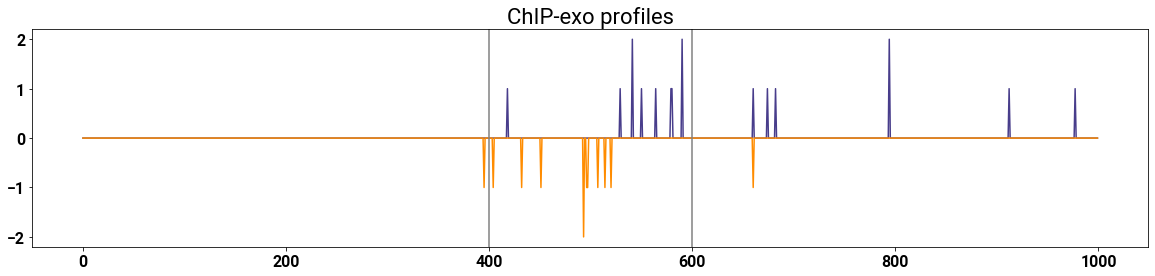

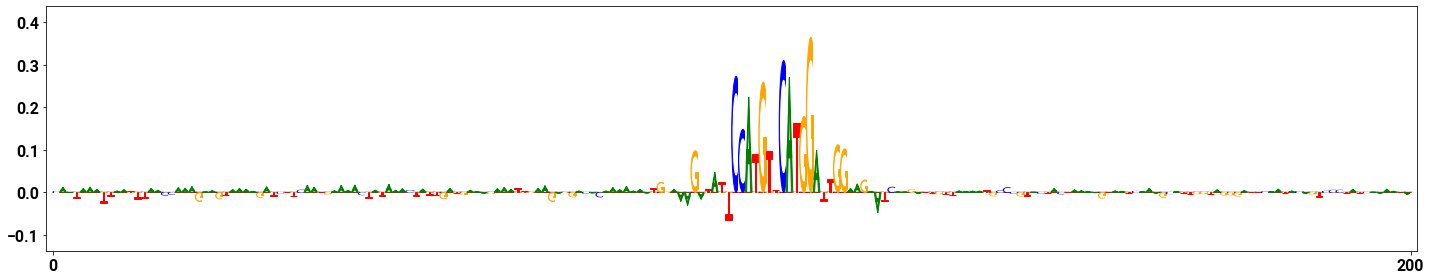

chr20:13145487-13145537 (index 15136)


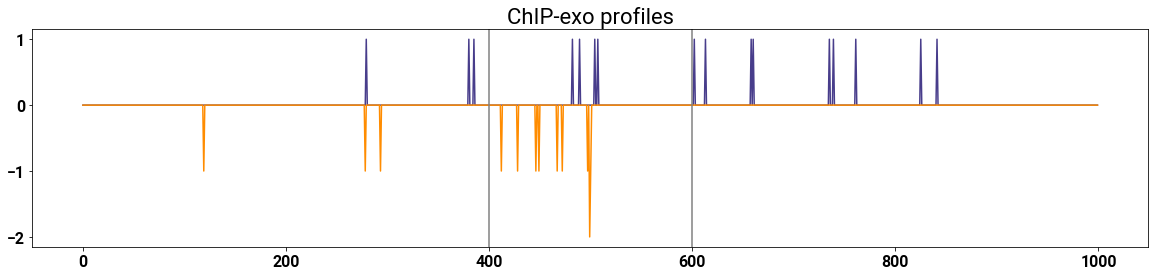

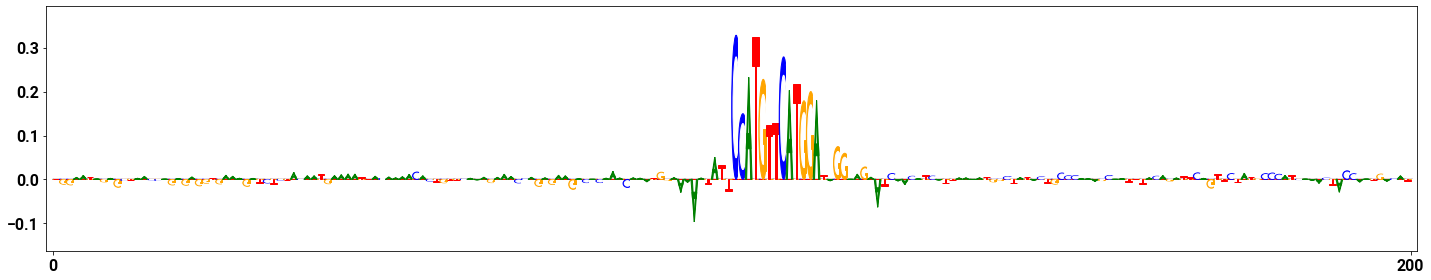

chr2:183198893-183198943 (index 2845)


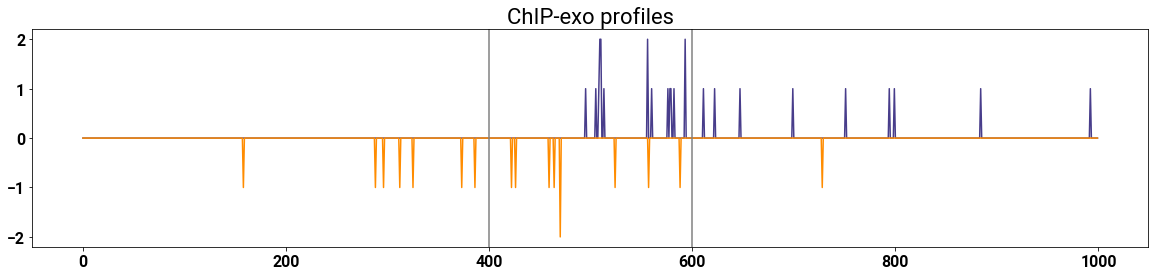

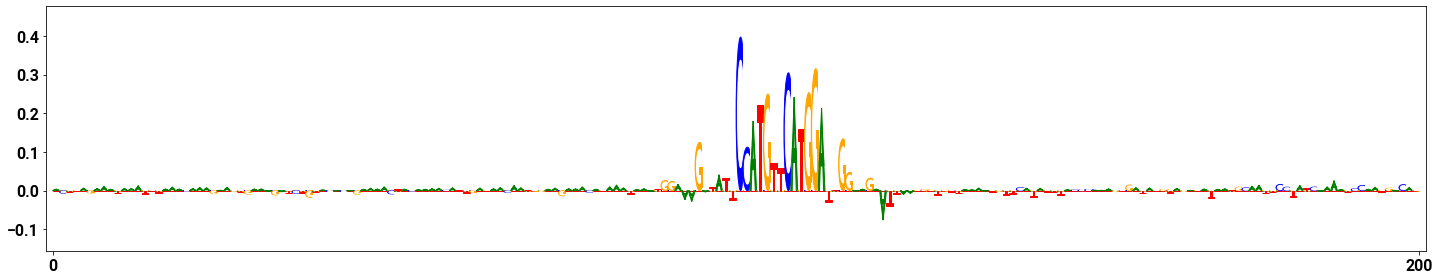

chr10:90950927-90950977 (index 10146)


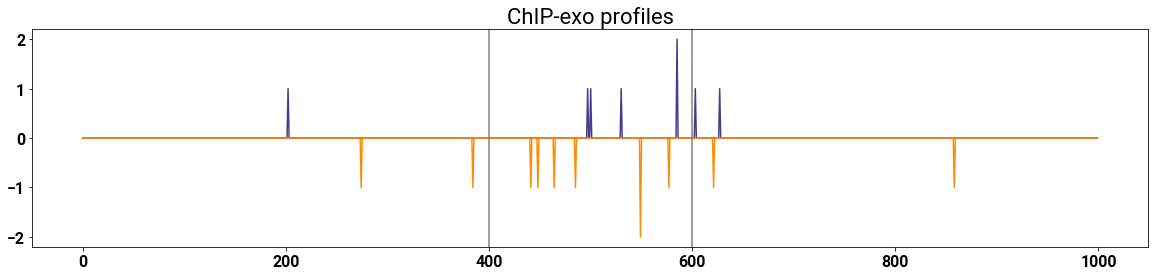

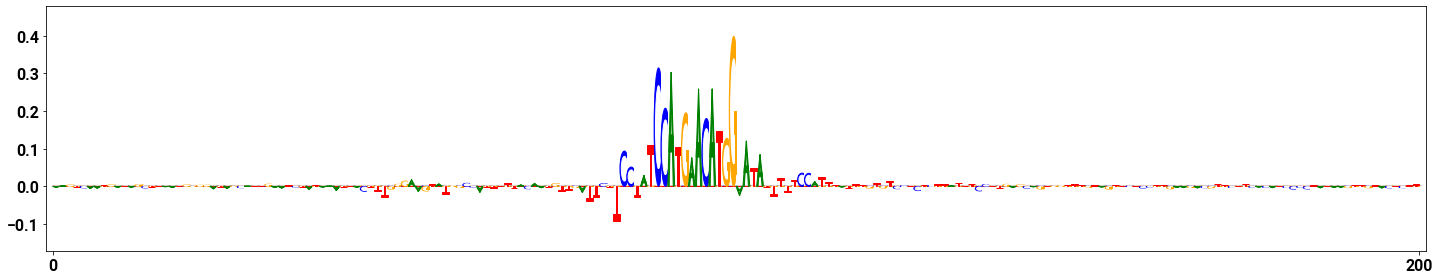

chrX:129398031-129398081 (index 16549)


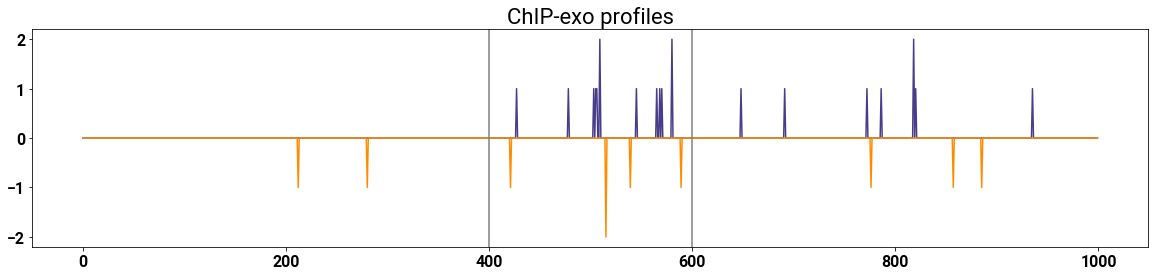

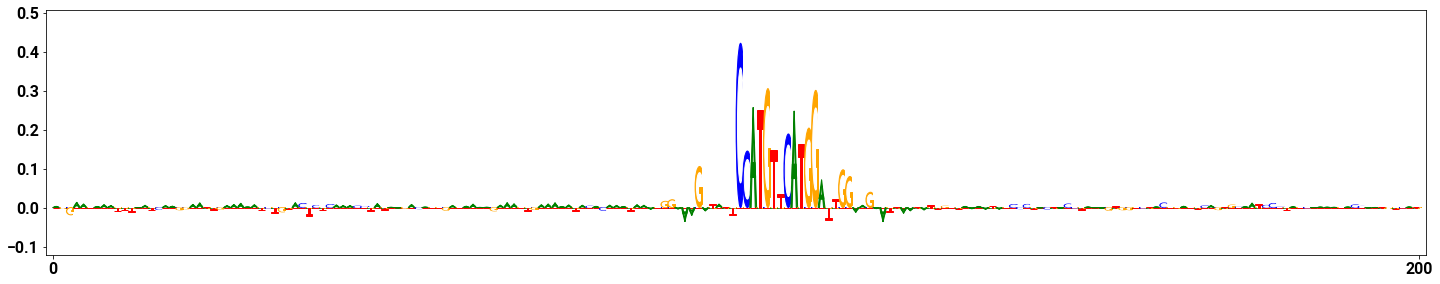

chr2:22724066-22724116 (index 2370)


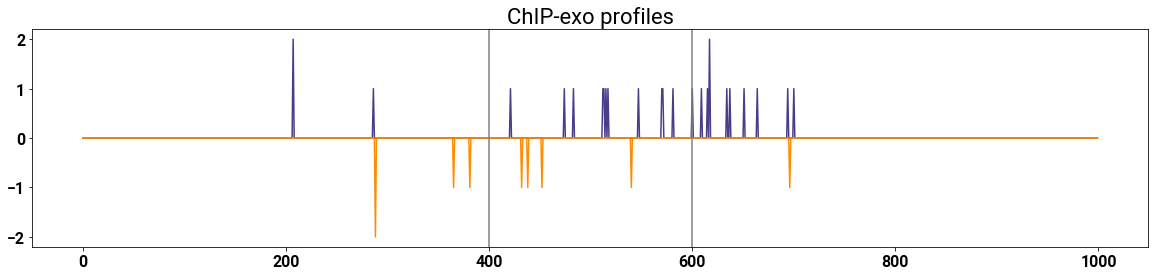

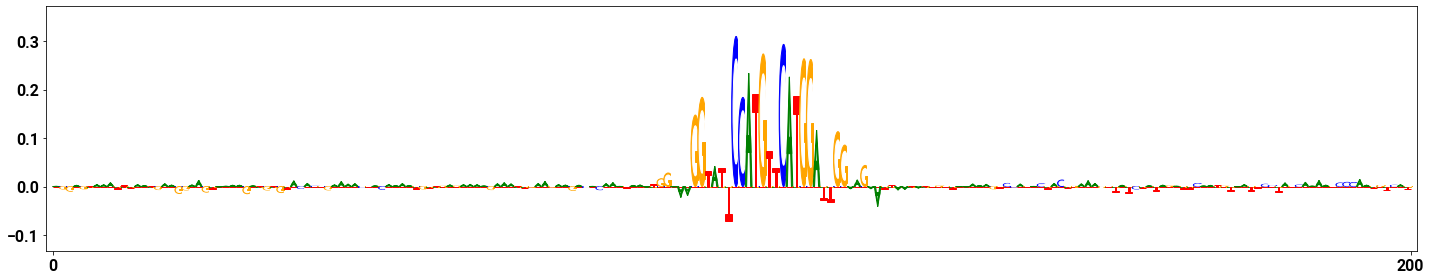

chr3:22515758-22515808 (index 3628)


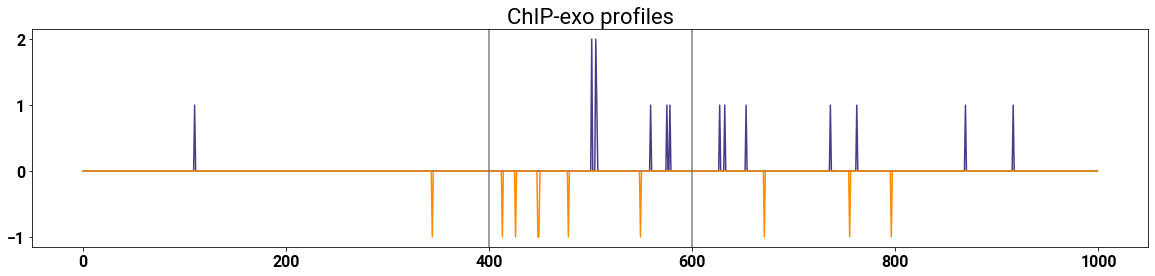

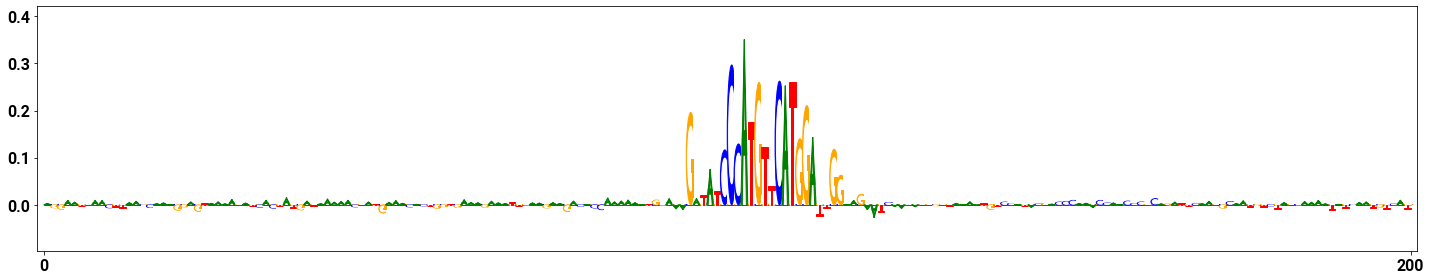

chr6:32258710-32258760 (index 6617)


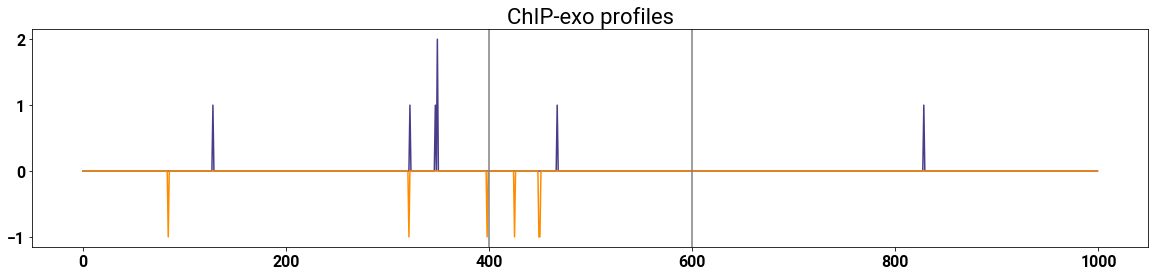

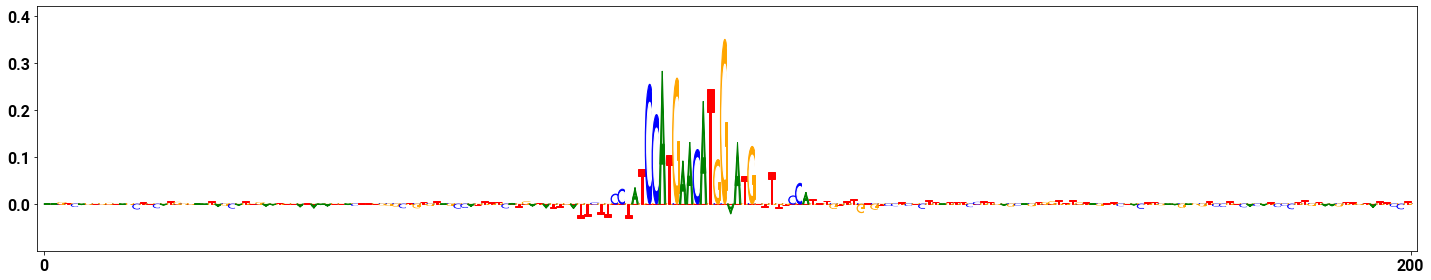

chr14:35839483-35839533 (index 12643)


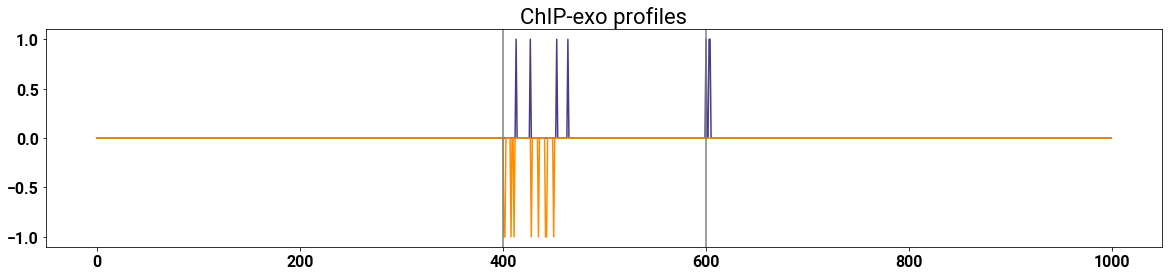

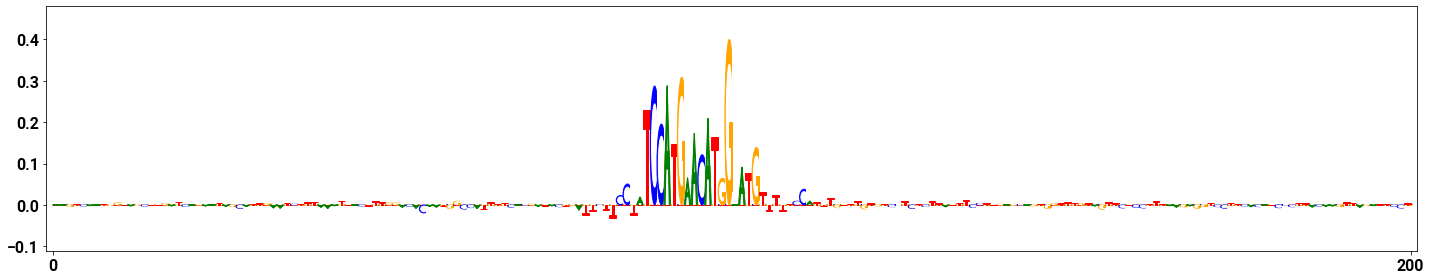

In [24]:
num_to_take = 10
hits = full_hits_table.sort_values(by="score", ascending=False).head(10)

for index, row in hits.iterrows():
    chrom, start, end = row["chrom"], row["start"], row["end"]
    print("%s:%d-%d (index %d)" % (chrom, start, end, index))
    
    if index == 8571:
        save_path = os.path.join(out_path, "ZNF248_hit_example_%d" % index)
    else:
        save_path = None
    plot_example_hit(chrom, start, end, save_path=save_path)